## Assignment 2 (50 marks)
#### =====================================================================================================
### Deadline: 09/28 11:59 pm
#### =====================================================================================================

### Problem 1: Perceptron Learning (15 marks)

The dataset `lab02_dataset_1.csv` has a *3-dimensional input space* and a class label of *Positive* and *Negative*. For this task, you are **not allowed** to use any *functionalities* of the `sklearn` module.

### 1.a (10 marks)

Write a function `my_perceptron()` which applies the perceptron algorithm (refer to the lecture slide covering linear separators for details of this algorithm) on the dataset to create a linear separator. `my_perceptron()` takes the dataset as its input and returns a ***3-dimensional weight vector*** which can be used to create the linear separator (assume `bias = 0`). Use the *initial weights* `w = [3.5,0.5,-2.5]`. Use a classification threshold of `99%` i.e., `my_perceptron()` will terminate once the misclassification rate is less than `1%`.

In [2]:
import numpy as np
import pandas as pd

def my_perceptron(X, y, w0=None, lr=1.0, tol=0.01, max_epochs=10000, shuffle=True, seed=0):
    rng = np.random.default_rng(seed)
    n, d = X.shape
    assert d == 3, "Expected 3D inputs"
    w = np.array(w0 if w0 is not None else np.zeros(d), dtype=float)
    for _ in range(max_epochs):
        idx = np.arange(n)
        if shuffle:
            rng.shuffle(idxs := idx)
        errors = 0
        for i in idx:
            pred = 1 if np.dot(w, X[i]) > 0 else -1  # bias = 0
            if pred != y[i]:
                w = w + lr * y[i] * X[i]
                errors += 1
        if errors / n < tol:
            break
    return w

# Load data
df = pd.read_csv("./lab02_dataset_1.csv")

# Detect columns
label_col = next((c for c in df.columns
                  if df[c].astype(str).str.contains("Positive|Negative", case=False, regex=True).any()),
                 df.columns[-1])
feature_cols = [c for c in df.columns if c != label_col][:3]

# Build X,y
X = df[feature_cols].to_numpy(dtype=float)
y = np.where(df[label_col].astype(str).str.strip().str.lower().eq("positive"), 1, -1)

# Train
w0 = np.array([3.5, 0.5, -2.5], dtype=float)
w = my_perceptron(X, y, w0=w0, lr=1.0, tol=0.01, max_epochs=10000, shuffle=True, seed=0)

print(w)  # <-- keep this line by itself


[0.06190299 5.29025832 0.14475301]


### 1.b (5 marks)

Create a *3D plot* which showcases the dataset in a 3D-space alongwith the *linear separator* you obtained from `my_perceptron()`. Use two different colors to represent the data points belonging in the two classes for ease of viewing.

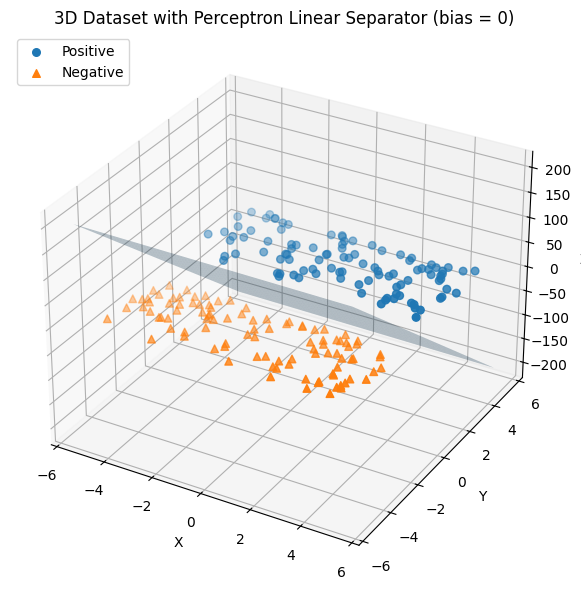

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Assumes df, feature_cols, X, y are already defined from 1.a and 'w' is learned
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Two classes, two markers/colors
pos = X[y == 1]
neg = X[y == -1]
ax.scatter(pos[:,0], pos[:,1], pos[:,2], label="Positive", s=30)
ax.scatter(neg[:,0], neg[:,1], neg[:,2], label="Negative", s=30, marker='^')

# Plane: w1*x + w2*y + w3*z = 0  =>  z = -(w1*x + w2*y)/w3
w1, w2, w3 = w
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
pad_x = 0.05 * (x_max - x_min if x_max > x_min else 1.0)
pad_y = 0.05 * (y_max - y_min if y_max > y_min else 1.0)

xx = np.linspace(x_min - pad_x, x_max + pad_x, 25)
yy = np.linspace(y_min - pad_y, y_max + pad_y, 25)
XX, YY = np.meshgrid(xx, yy)

if abs(w3) < 1e-12:
    # vertical-ish plane: just span Z over data range
    z_min, z_max = X[:,2].min(), X[:,2].max()
    ZZ = np.linspace(z_min, z_max, 25)[None, :].repeat(XX.shape[0], axis=0)
else:
    ZZ = -(w1 * XX + w2 * YY) / w3

ax.plot_surface(XX, YY, ZZ, alpha=0.3, linewidth=0, antialiased=True)

ax.set_xlabel(feature_cols[0])
ax.set_ylabel(feature_cols[1])
ax.set_zlabel(feature_cols[2])
ax.set_title("3D Dataset with Perceptron Linear Separator (bias = 0)")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()  # <-- nothing after this line


### Problem 2: SVM Classification (35 marks)

`lab02_dataset_2.xlsx` contains the claim history of 27,513 homeowner policies. The following table describes the eleven columns in the dataset.

| Name | Description |
| --- | --- |
| policy | Policy Identifier |
| exposure | Duration a Policy exposed in a Year |
| num_claims | Number of Claims in a Year |
| amt_claims | Total Claim Amount in a Year	|
| f_primary_age_tier | Age Tier of Primary Insured |
| f_primary_gender | Gender of Primary Insured |
| f_marital | Marital Status of Primary Insured |
| f_residence_location | Location of Residence Property |
| f_fire_alarm_type | Fire Alarm Type |
| f_mile_fire_station | Distance to Nearest Fire Station |
| f_aoi_tier | Amount of Insurance Tier |

We want to predict the *Frequency* which is the *number of claims per unit of exposure* using the above features.  We first divide the reported number of claims by the exposure. This gives us the *Frequency*.  Next, we put the policies into five groups according to their *Frequency* values. We will use this *Group* as our target variable which has five classes.

| Group | Values |
| :--- | :--- |
| 0 | Frequency = 0 |
| 1 | 0 < Frequency <= 1 |
| 2 | 1 < Frequency <= 2 |
| 3 | 2 < Frequency <= 3 |
| 4 | 3 < Frequency |

### 2.a (6 marks)
Create a new column for the dataset which will indiciate the *Frequency Group* and output the updated dataset.

In [4]:
import pandas as pd
df = pd.read_excel("./lab02_dataset_2.xlsx")
df['Frequency'] = df['num_claims'] / df['exposure']
def assign_group(freq):
    if freq == 0:
        return 0
    elif 0 < freq <= 1:
        return 1
    elif 1 < freq <= 2:
        return 2
    elif 2 < freq <= 3:
        return 3
    else:
        return 4

df['Group'] = df['Frequency'].apply(assign_group)
df.to_excel("lab02_dataset_2_with_groups.xlsx", index=False)
print("Updated dataset saved as lab02_dataset_2_with_groups.xlsx")
print(df[['policy', 'exposure', 'num_claims', 'Frequency', 'Group']].head())


Updated dataset saved as lab02_dataset_2_with_groups.xlsx
   policy  exposure  num_claims  Frequency  Group
0  P00001       1.0           0        0.0      0
1  G00002       1.0           0        0.0      0
2  A00003       1.0           2        2.0      2
3  P00004       1.0           1        1.0      1
4  G00005       1.0           1        1.0      1


### 2.b (6 marks)
There are seven categorial features in the dataset namely, *f_aoi_tier, f_primary_age_tier, f_fire_alarm_type, f_marital, f_mile_fire_station, f_primary_gender, f_residence_location*. Display all the unique values of these seven categories.

In [5]:
categorical_features = [
    "f_aoi_tier",
    "f_primary_age_tier",
    "f_fire_alarm_type",
    "f_marital",
    "f_mile_fire_station",
    "f_primary_gender",
    "f_residence_location"
]
unique_values = {col: df[col].unique().tolist() for col in categorical_features}
unique_values

{'f_aoi_tier': ['351K - 600K', '< 100K', '100K - 350K', '601K - 1M', '> 1M'],
 'f_primary_age_tier': ['21 - 27', '38 - 60', '28 - 37', '> 60', '< 21'],
 'f_fire_alarm_type': ['Alarm Service', nan, 'Standalone'],
 'f_marital': ['Married', 'Un-Married', 'Not Married'],
 'f_mile_fire_station': ['< 1 mile',
  '1 - 5 miles',
  '> 10 miles',
  '6 - 10 miles'],
 'f_primary_gender': ['Male', 'Female'],
 'f_residence_location': ['Urban', 'Suburban', 'Rural']}

### 2.c (6 marks)
We will train SVM models using those seven categorical features. However, their values are currently all categorical data, but SVM requires them to be numerical. Perform `One-hot Encoding` on these features to obtain an updated dataset which has only numerical values.

In [15]:
cat_cols = [
    "f_aoi_tier",
    "f_primary_age_tier",
    "f_fire_alarm_type",
    "f_marital",
    "f_mile_fire_station",
    "f_primary_gender",
    "f_residence_location",
]
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=False)
df_enc.iloc[:, -20:].head()

,f_aoi_tier_> 1M,f_primary_age_tier_21 - 27,f_primary_age_tier_28 - 37,f_primary_age_tier_38 - 60,f_primary_age_tier_< 21,f_primary_age_tier_> 60,f_fire_alarm_type_Alarm Service,f_fire_alarm_type_Standalone,f_marital_Married,f_marital_Not Married,f_marital_Un-Married,f_mile_fire_station_1 - 5 miles,f_mile_fire_station_6 - 10 miles,f_mile_fire_station_< 1 mile,f_mile_fire_station_> 10 miles,f_primary_gender_Female,f_primary_gender_Male,f_residence_location_Rural,f_residence_location_Suburban,f_residence_location_Urban
0,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,True
1,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,True,False
2,False,False,False,True,False,False,False,True,True,False,False,False,False,True,False,True,False,False,True,False
3,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False
4,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False,False,True,False


### 2.d (6 marks)
Divide the observations into training and testing partitions. Observations whose *Policy Identifier* starts with the letters A, G, and P will go to the training partition. The remaining observations go to the testing partition. Output the total number of policies present in the Training partition and Testing partition.

In [16]:
is_train = df_enc["policy"].astype(str).str.startswith(("A", "G", "P"))
train, test = df_enc[is_train].copy(), df_enc[~is_train].copy()
print("Total policies in Training partition:", train.shape[0])
print("Total policies in Testing partition:", test.shape[0])

Total policies in Training partition: 20661
Total policies in Testing partition: 6852


### 2.e (6 marks)
Train an SVM model using [`LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). The input features will be the encoded version of the feature set *f_aoi_tier, f_primary_age_tier, f_fire_alarm_type, f_marital, f_mile_fire_station, f_primary_gender, f_residence_location* and the output is the *Frequency Group*. Use `verbose=1` to observe the optimization steps during the training process.

In [19]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
cat_cols = [
    "f_aoi_tier",
    "f_primary_age_tier",
    "f_fire_alarm_type",
    "f_marital",
    "f_mile_fire_station",
    "f_primary_gender",
    "f_residence_location",
]
encoded_prefixes = tuple(c + "_" for c in cat_cols)
feature_cols = [c for c in df_enc.columns if c.startswith(encoded_prefixes)]
X_train = train[feature_cols].values
y_train = train["Group"].values
X_test  = test[feature_cols].values
y_test  = test["Group"].values
svm = LinearSVC(random_state=0, max_iter=5000, verbose=1)
svm.fit(X_train, y_train)

[LibLinear]

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,1
,random_state,0


### 2.f (5 marks)
Compute and output the accuracy score on the testing partition.

In [18]:
from sklearn.metrics import accuracy_score
y_pred_test = svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy on Testing Partition:", test_accuracy)

Accuracy on Testing Partition: 0.5634851138353766
